In [ ]:
import sys
import json
import pickle

from functools import reduce
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import udf, mean, lit, stddev, col, expr, when
from pyspark.sql.types import DoubleType, ArrayType, ShortType, LongType, IntegerType
import pandas as pd
from collections import OrderedDict
from datetime import date
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

from pyspark.ml import Pipeline, PipelineModel

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml import PipelineModel

In [ ]:
spark = SparkSession\
    .builder\
    .appName("AvroKeyInputFormat")\
    .getOrCreate()

In [ ]:
STORAGE_ACCOUNT_SUFFIX = 'core.windows.net'
STORAGE_ACCOUNT_NAME = 'stgw74e5yvuyvfs2'
STORAGE_ACCOUNT_KEY = 'CKXt/8SpgY6JHfVwBQUkwBCDeBKyJzQV10sgut3L4dS/bjKlSxQsPedHkrI7td8I0NBWJoQOSkcChGo1MIf9Cw=='
TELEMETRY_CONTAINER_NAME = 'telemetry'
IOT_HUB_NAME = 'iothub-w74e5yvuyvfs2'

wasbUrlInput = "wasb://{0}@{1}.blob.{2}/{3}/*/*/*/*/*/*".format(
            TELEMETRY_CONTAINER_NAME,
            STORAGE_ACCOUNT_NAME,
            STORAGE_ACCOUNT_SUFFIX,
            IOT_HUB_NAME)

sc = spark.sparkContext

hc = sc._jsc.hadoopConfiguration()
hc.set("avro.mapred.ignore.inputs.without.extension", "false")
hc.set("fs.azure.account.key.{}.blob.core.windows.net".format(STORAGE_ACCOUNT_NAME), STORAGE_ACCOUNT_KEY)

sql = SQLContext(sc)

df = sql.read.format("com.databricks.spark.avro").load(wasbUrlInput)

In [ ]:
df.printSchema()

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- Properties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- SystemProperties: map (nullable = true)
 |    |-- key: string
 |    |-- value: string (valueContainsNull = true)
 |-- Body: binary (nullable = true)



In [ ]:
sample_rate = 8000

def extract_double(c):
    return udf(lambda x: float(pickle.loads(x)[c]), DoubleType())

def extract_array(c):
    return udf(lambda x: pickle.loads(x)[c], ArrayType(ShortType()))

def extract_amplitude_spectrum(c):
    def m(x):
        ampl = np.abs(np.fft.fft(pickle.loads(x)[c])) / sample_rate
        return ampl[:sample_rate // 2 + 1].tolist()
                      
    return udf(m, ArrayType(DoubleType()))

def extract_dominant_frequencies(index):
    def m(ff):
        freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
        return [float(f[index]) for f in sorted(list(zip(freq, ff)), key = lambda x: x[1], reverse = True)]
    
    return udf(m, ArrayType(DoubleType()))


dfa = (df
       .withColumn('machineID', df.SystemProperties['connectionDeviceId'])
       .withColumn("speed", extract_double("speed")(df.Body))
       .withColumn("temperature", extract_double("temperature")(df.Body))
       .withColumn("pressure", extract_double("pressure")(df.Body))
       .withColumn("vibration", extract_array("vibration")(df.Body))
       .withColumn("fft", extract_amplitude_spectrum("vibration")(df.Body))
       .drop('Properties', 'SystemProperties', 'Body'))

dfa = (dfa
       .withColumn("dominant_frequencies", extract_dominant_frequencies(0)(dfa.fft))
       .withColumn("dominant_frequencies_amplitudes", extract_dominant_frequencies(1)(dfa.fft)))

In [ ]:
dfa.printSchema()
dfa.limit(5).toPandas().head(5)

root
 |-- EnqueuedTimeUtc: string (nullable = true)
 |-- machineID: string (nullable = true)
 |-- speed: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: array (nullable = true)
 |    |-- element: short (containsNull = true)
 |-- fft: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dominant_frequencies_amplitudes: array (nullable = true)
 |    |-- element: double (containsNull = true)



,EnqueuedTimeUtc,machineID,speed,temperature,pressure,vibration,fft,dominant_frequencies,dominant_frequencies_amplitudes
0,2018-02-26T02:16:37.0710000Z,machine00003,1432.974609,63.883020,2998.076574,"[-17664, -11084, -3331, 4786, 12500, 18931, 23...","[9.963375, 9.140917194676298, 9.26975296482886...","[406.0, 287.0, 48.0, 286.0, 96.0, 119.0, 95.0,...","[13084.042747030253, 1570.2637484801637, 1191...."
1,2018-02-26T02:16:37.2740000Z,machine00003,1432.987305,63.953791,2998.006789,"[-20805, -14749, -7074, 1411, 9731, 17357, 234...","[2.8835, 3.2612204369293267, 2.770588482157916...","[406.0, 287.0, 48.0, 286.0, 96.0, 119.0, 95.0,...","[13074.4633863111, 1586.4190468895897, 1196.66..."
2,2018-02-26T02:16:37.5090000Z,machine00003,1432.993652,64.024469,2997.937005,"[-12292, -6769, -7, 7129, 13901, 19600, 23432,...","[30.07075, 31.574618467607873, 30.751527718851...","[406.0, 287.0, 48.0, 286.0, 96.0, 119.0, 95.0,...","[13073.66575550368, 1590.2731536118642, 1171.4..."
3,2018-02-26T02:16:37.7120000Z,machine00003,1432.996826,64.095053,2997.867222,"[-21415, -12492, -2421, 7828, 17486, 25519, 31...","[32.007375, 30.31661929608589, 31.577379064738...","[406.0, 287.0, 48.0, 286.0, 96.0, 119.0, 95.0,...","[13073.603265677728, 1591.5637397340552, 1171...."
4,2018-02-26T02:16:37.9150000Z,machine00003,1432.998413,64.165543,2997.797438,"[-16699, -10284, -3185, 3766, 9915, 14561, 171...","[1.300625, 2.0970027516800367, 1.8066382908417...","[406.0, 287.0, 48.0, 286.0, 96.0, 119.0, 95.0,...","[13071.041913879537, 1591.7713277458597, 1201...."


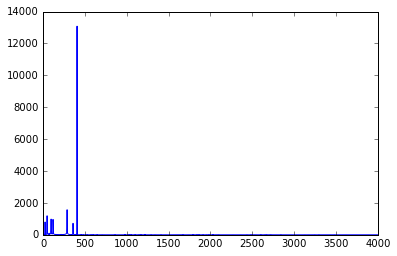

In [ ]:
#dfa.limit(5).toPandas()
plt.plot(dfa.first().fft)
plt.show()

In [ ]:
k = dfa.where(dfa.machineID == 'machine00002').orderBy('EnqueuedTimeUtc').select('vibration').take(100)
k = np.concatenate(np.array([x.vibration for x in k]))

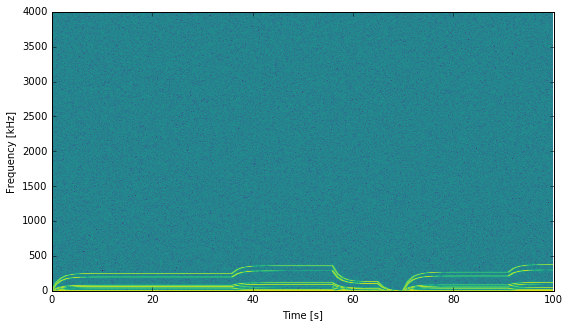

In [ ]:
freqs, times, Sx = signal.spectrogram(k, fs=8000, window='hanning',
                                      nperseg=4096, noverlap=4096 - 100,
                                      detrend=False, scaling='spectrum')
f, ax = plt.subplots(figsize=(9, 5))
ax.pcolormesh(times, freqs, 10 * np.log10(Sx), cmap='viridis')
ax.set_ylabel('Frequency [kHz]')
ax.set_xlabel('Time [s]')
plt.show()

In [ ]:
freq = np.fft.fftfreq(sample_rate, d = 1/sample_rate)[:sample_rate // 2 + 1]
max_freq = sorted(list(zip(freq, dfa.sample(False, 0.1, seed=0).first().fft)), key = lambda x: x[1], reverse = True)[10 : ]
pdf = pd.DataFrame.from_records(max_freq)
pdf.head()

,0,1
0,288.0,457.073098
1,285.0,394.846052
2,47.0,373.003987
3,94.0,319.597909
4,97.0,296.155912


In [ ]:
frequency_features = 3
dfa = reduce(lambda _df, i: _df.withColumn('f{0}'.format(i), _df.dominant_frequencies[i]), range(frequency_features), dfa)
dfa = reduce(lambda _df, i: _df.withColumn('a{0}'.format(i), _df.dominant_frequencies_amplitudes[i]), range(frequency_features), dfa)
dfa = dfa.drop('vibration', 'fft', 'dominant_frequencies', 'dominant_frequencies_amplitudes')

In [ ]:
dependent_features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc', 'speed']]
dfa = reduce(lambda _df, f: _df.withColumn('{0}_n'.format(f), col(f) / col('speed')), dependent_features, dfa)

In [ ]:
dfa.limit(5).toPandas().head()

,EnqueuedTimeUtc,machineID,speed,temperature,pressure,f0,f1,f2,a0,a1,a2,temperature_n,pressure_n,f0_n,f1_n,f2_n,a0_n,a1_n,a2_n
0,2018-02-26T02:16:37.0710000Z,machine00003,1432.974609,63.883020,2998.076574,406.0,287.0,48.0,13084.042747,1570.263748,1191.386579,0.044581,2.092205,0.283327,0.200283,0.033497,9.130687,1.095807,0.831408
1,2018-02-26T02:16:37.2740000Z,machine00003,1432.987305,63.953791,2998.006789,406.0,287.0,48.0,13074.463386,1586.419047,1196.665475,0.044630,2.092138,0.283324,0.200281,0.033496,9.123921,1.107071,0.835084
2,2018-02-26T02:16:37.5090000Z,machine00003,1432.993652,64.024469,2997.937005,406.0,287.0,48.0,13073.665756,1590.273154,1171.489380,0.044679,2.092080,0.283323,0.200280,0.033496,9.123324,1.109756,0.817512
3,2018-02-26T02:16:37.7120000Z,machine00003,1432.996826,64.095053,2997.867222,406.0,287.0,48.0,13073.603266,1591.563740,1171.614925,0.044728,2.092026,0.283322,0.200280,0.033496,9.123260,1.110654,0.817598
4,2018-02-26T02:16:37.9150000Z,machine00003,1432.998413,64.165543,2997.797438,406.0,287.0,48.0,13071.041914,1591.771328,1201.177588,0.044777,2.091975,0.283322,0.200279,0.033496,9.121463,1.110798,0.838227


In [ ]:
features = [c for c in dfa.columns if c not in ['machineID', 'EnqueuedTimeUtc']]

# assemble features
va = VectorAssembler(inputCols=(features), outputCol='features')

# this is a hack!! In the current simulated dataset, there are 4 machines: machine 0 is "good," 
# whereas the rest are experiencing different failures. This will eventually be produced by merging 
# telemetry with the "maintenance log"
feat_data = va.transform(dfa).select('machineID', 'features').withColumn('label_e', dfa.machineID.substr(-1, 1).cast(IntegerType()))

feat_data.cache()

feat_data.limit(10).toPandas().head()

,machineID,features,label_e
0,machine00003,"[1432.97460937, 63.8830195751, 2998.07657368, ...",3
1,machine00003,"[1432.98730469, 63.9537912774, 2998.00678939, ...",3
2,machine00003,"[1432.99365234, 64.024469246, 2997.93700541, 4...",3
3,machine00003,"[1432.99682617, 64.0950532238, 2997.86722159, ...",3
4,machine00003,"[1432.99841309, 64.165543166, 2997.79743784, 4...",3


In [ ]:
# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label_e", outputCol="indexedLabel").fit(feat_data)

In [ ]:
training, test = feat_data.randomSplit([0.8, 0.2], seed=12345)
print(training.count())
print(test.count())
feat_data.limit(5).toPandas().head()

6676
1646


,machineID,features,label_e
0,machine00003,"[1432.97460937, 63.8830195751, 2998.07657368, ...",3
1,machine00003,"[1432.98730469, 63.9537912774, 2998.00678939, ...",3
2,machine00003,"[1432.99365234, 64.024469246, 2997.93700541, 4...",3
3,machine00003,"[1432.99682617, 64.0950532238, 2997.86722159, ...",3
4,machine00003,"[1432.99841309, 64.165543166, 2997.79743784, 4...",3


In [ ]:
model_type = 'DecisionTree' # Use 'DecisionTree', or 'RandomForest'

# train a model.
if model_type == 'DecisionTree':
    model = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",
                                      # Maximum depth of the tree. (>= 0) 
                                      # E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'
                                      maxDepth=15,
                                      # Max number of bins for discretizing continuous features. 
                                      # Must be >=2 and >= number of categories for any categorical feature.
                                      maxBins=32, 
                                      # Minimum number of instances each child must have after split. 
                                      # If a split causes the left or right child to have fewer than 
                                      # minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.
                                      minInstancesPerNode=1, 
                                      # Minimum information gain for a split to be considered at a tree node.
                                      minInfoGain=0.0, 
                                      # Criterion used for information gain calculation (case-insensitive). 
                                      # Supported options: entropy, gini')
                                      impurity="gini")

    ##=======================================================================================================================
    #elif model_type == 'GBTClassifier':
    #    cls_mthd = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
    ##=======================================================================================================================
else:    
    model = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                                      # Passed to DecisionTreeClassifier
                                      maxDepth=15, 
                                      maxBins=32, 
                                      minInstancesPerNode=1, 
                                      minInfoGain=0.0,
                                      impurity="gini",
                                      # Number of trees to train (>= 1)
                                      numTrees=50, 
                                      # The number of features to consider for splits at each tree node. 
                                      # Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].
                                      featureSubsetStrategy="sqrt", 
                                      # Fraction of the training data used for learning each 
                                      # decision tree, in range (0, 1].' 
                                      subsamplingRate = 0.632)

# chain indexers and model in a Pipeline
pipeline_cls_mthd = Pipeline(stages=[labelIndexer, featureIndexer, model])

# train model.  This also runs the indexers.
model_pipeline = pipeline_cls_mthd.fit(training)

In [ ]:
# make predictions. The Pipeline does all the same operations on the test data
predictions = model_pipeline.transform(test)

# Create the confusion matrix for the multiclass prediction results
# This result assumes a decision boundary of p = 0.5
conf_table = predictions.stat.crosstab('indexedLabel', 'prediction')
confuse = conf_table.toPandas().sort_values(by=['indexedLabel_prediction'])
confuse.head()

,indexedLabel_prediction,0.0,1.0,2.0,3.0
3,0.0,421,0,0,0
1,1.0,0,446,0,0
0,2.0,2,0,373,0
2,3.0,1,0,1,402
